# Importing Libraries

In the following block we are just importing the main libraries used for creating a NN and processing its output

In [1]:
from __future__ import print_function
import argparse
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
from models.binarized_modules import  BinarizeLinear,BinarizeConv2d
from models.binarized_modules import  Binarize,HingeLoss
import matplotlib.pyplot as plt

# Load MNIST

In the incoming block the MNIST dataset is created and loaded to the standard DataLoader of pytorch. This allow to simply call train_data and test_data when training the network without having to manually create the batches. 

In [2]:
class ThresholdTransform(object):
    def __init__(self, thr_255):
        self.thr = thr_255   # input threshold for [0..255] gray level, convert to [0..1]

    def __call__(self, x):
        x[x >= 0] = 1
        x[x <= 0] = 0
        
        return x  # do not change the data type


    

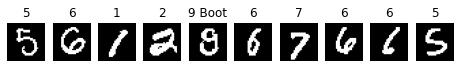

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0.,

In [3]:
# Preprocessing data: convert to tensors and normalize by subtracting dataset
# mean and dividing by std.
# We need to recall that the data is normalized when doing the ASIC implementation 
# The dummy input we feed in the ASIC must be normalized as well 

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,)),
                                ThresholdTransform(thr_255=0)])

#transforms.Resize((2,2)),

# Get data from torchvision.datasets
train_data = datasets.MNIST('../data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('../data', train=False, download=True, transform=transform)



# Define data loaders used to iterate through dataset
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data)



# Show some example images and the associated label to verify that the data is loaded correctly 

labels_map = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9 Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 10, 1
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

imgt, labelt = test_data[0]
print(imgt)

# MNIST classification with Binary Neural Network
## Sign function 
The function implemented below is the sign() function mentioned in the paper. However, this function is not used for training as it would not allow for gradient descent calculation. The idea is to use this function after the train has been performed (TODO). 

In [4]:
def my_sign(a):
    
    a_buff = torch.empty(a.shape)
    for idx, element in enumerate(a):
        for idy, sub_element in enumerate(element):
            if(sub_element >= 0):
                a_buff[idx][idy] = 1
            else:
                a_buff[idx][idy] = -1
            
    return a_buff

## Create a class for the pytorch BNN
Here I am basically creating my own definition of the network, the __init__ is the constructor and creates the class instances of the layer I want to use. The foreward function instead, perform the foreward pass of the network based on the order on which I put the layers previously created. 

In [5]:
class MY_BNN(nn.Module):
    
    def __init__(self, in_features, hidden_dim, out_features):
        super(MY_BNN, self).__init__()
        self.fc1 = BinarizeLinear(in_features, hidden_dim, bias = False)
        self.htanh1 = nn.Hardtanh()
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = BinarizeLinear(hidden_dim, hidden_dim, bias = False)
        self.htanh2 = nn.Hardtanh()
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = BinarizeLinear(hidden_dim, hidden_dim, bias = False)
        self.htanh3 = nn.Hardtanh()
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.fc4 = BinarizeLinear(hidden_dim, out_features, bias = False)
        self.drop=nn.Dropout(0.25)
        self.logsoftmax=nn.LogSoftmax()

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)    
        x = self.bn1(x)    
        x = self.htanh1(x) 
        x = self.fc2(x)    
        x = self.bn2(x)    
        x = self.htanh2(x)
        x = self.fc3(x)
        x = self.drop(x)
        x = self.bn3(x)
        x = self.htanh3(x)
        x = self.fc4(x)
        #x = self.htanh3(x)
        return self.logsoftmax(x)
        #return x


## Initialize parameters and criterion of the network 

In [6]:
# Initialize Pytorch network

in_features = 28*28 # this is because the input image is flatten into and array of 28*28, 28 being the number of pixels
hidden_dim = 100 # number of neurons in an hidden layer
hidden_layers = 4
out_features = 10 # we need to classify 10 classes of number 0 to 10 
learning_rate = 0.003 # this is the step that we take to move in the direction of the gradient 


criterion = nn.CrossEntropyLoss()  # Meaning that we use cross entropy as a loss function 
epochs = 10 # number of times we are going across the full dataset 



model = MY_BNN(in_features, hidden_dim, out_features)

#find number of param 
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of bytes required",pytorch_total_params /8/1e6 , "Mbyte")

optimizer = optim.Adam(model.parameters(), learning_rate) # Adam algorithm to optimize change of learning_rate


Number of bytes required 0.0125 Mbyte


## Definition of the training function

In [7]:
train_losses = []  # hold the loss for each batch -> used to display training afterwards 

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        

        if epoch%40==0:
            optimizer.param_groups[0]['lr']=optimizer.param_groups[0]['lr']*0.1

        optimizer.zero_grad()
        loss.backward()
        for p in list(model.parameters()):
            #print("inside for")
            if hasattr(p,'org'):
                p.data.copy_(p.org)
        optimizer.step()
        for p in list(model.parameters()):
            if hasattr(p,'org'):
                p.org.copy_(p.data.clamp_(-1,1))
                
        #print(output)
        #print(target)
       # correct = torch.argmax(output, axis=1) == torch.argmax(target, axis=1)
        #train_accs.append(torch.sum(correct)/len(y_pred))
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    train_losses.append(loss)

In [ ]:
#model.bn2.weight
for p in list(model.parameters()):
    print(p.data)


## The training loop

In [8]:
for epoch in range(1, epochs + 1):
    train(epoch)

/var/folders/8f/j0yzvf055y7c23h6ltl5b3pr0000gn/T/ipykernel_82168/4020480207.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.logsoftmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 14.967752
Train Epoch: 1 [6400/60000 (11%)]	Loss: 3.314790
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.034814
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.846137
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.116923
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.709789
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.268419
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.156369
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.674825
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.461180
Train Epoch: 2 [0/60000 (0%)]	Loss: 1.864107
Train Epoch: 2 [6400/60000 (11%)]	Loss: 3.047797
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.725594
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.377731
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.481951
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.251547
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.868512
Train Epoch: 2 [44800/60000 (75%)]	Loss: 3.529536
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.438846
Train Epoch: 2 [57600/60000 (96%)]	Loss: 1.476863
Train Epoch

## Display loss vs iterations

In [ ]:
new = []
for element in train_losses:
    new.append(element.detach().numpy())
    
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(new)
plt.grid()
plt.savefig('foo.pdf')

## Define a function for testing the trained network

In [9]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
       
            data, target = Variable(data), Variable(target)
            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

## Test it
After this section the accuracy of the trained network will be printed

In [10]:
test()

/var/folders/8f/j0yzvf055y7c23h6ltl5b3pr0000gn/T/ipykernel_82168/4020480207.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.logsoftmax(x)



Test set: Average loss: 1.1293, Accuracy: 9365/10000 (94%)



## Test a single prediction after training

In [ ]:
img, label = test_data[1]
print(label)
plt.imshow(img.squeeze(), cmap="gray")
output = model(img)
print(output)
pred = output.data.max(1, keepdim=True)[1]
print(pred)

## Printing the weights
This section must be refined to make sure that I am able to print the weight for each layer in a proper manner. 

In [ ]:
for param in model.parameters():
    print(param)

In [ ]:
print(model.fc1.weight)
print(model.fc1.bias)

In [ ]:
print(model.fc2.weight)
print(model.fc2.bias)

In [ ]:
print(model.fc3.weight)
print(model.fc3.bias)

In [ ]:
print(model.fc3.weight.shape)
print(model.fc3.bias)

In [ ]:
print(model.fc4.weight)
print(model.fc4.bias)

In [ ]:
print(model.bn1.weight)
print(model.fc4.bias)

## Save network weights in a csv format

In [11]:
#First convert all network layers into numpy 
numpy_fc1 = model.fc1.weight.data.cpu().detach().numpy()
numpy_fc2 = model.fc2.weight.data.cpu().detach().numpy()
numpy_fc3 = model.fc3.weight.data.cpu().detach().numpy()
numpy_fc4 = model.fc4.weight.data.cpu().detach().numpy()


#Convert numpy to pandas dataframe 
df_fc1 = pd.DataFrame(numpy_fc1).astype(int)
df_fc2 = pd.DataFrame(numpy_fc2).astype(int)
df_fc3 = pd.DataFrame(numpy_fc3).astype(int)
df_fc4 = pd.DataFrame(numpy_fc4).astype(int)

df_fc1[:] = df_fc1[:].replace([-1],0)
df_fc2[:] = df_fc2[:].replace([-1],0)
df_fc3[:] = df_fc3[:].replace([-1],0)
df_fc4[:] = df_fc4[:].replace([-1],0)



#Export to csv with pandas 
df_fc1.to_csv('baseline/W_fc1.txt',index=False,header=False)
df_fc2.to_csv('baseline/W_fc2.txt',index=False,header=False)
df_fc3.to_csv('baseline/W_fc3.txt',index=False,header=False)
df_fc4.to_csv('baseline/W_fc4.txt',index=False,header=False)

# Test binarized
I know want to test if the network still infers correctly if I have the sign instead of the hardtanh

In [14]:
class MY_BNN_test(nn.Module):

    
    def __init__(self, in_features, hidden_dim, out_features):
        super(MY_BNN_test, self).__init__()

        self.fc1 = BinarizeLinear(in_features, hidden_dim, bias = False)
        self.fc2 = BinarizeLinear(hidden_dim, hidden_dim, bias = False)
        self.fc3 = BinarizeLinear(hidden_dim, hidden_dim, bias = False)
        self.fc4 = BinarizeLinear(hidden_dim, out_features, bias = False)


    def forward(self, x):
        #print("in fws")
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = my_sign(x)
        x = self.fc2(x)
        x = my_sign(x)
        x = self.fc3(x)
        x = my_sign(x)
        x = self.fc4(x)
        #x = my_sign(x)
        return x


In [15]:
model_test = MY_BNN_test(in_features, hidden_dim, out_features)
model_test.fc1.weight = model.fc1.weight
model_test.fc2.weight = model.fc2.weight
model_test.fc3.weight = model.fc3.weight
model_test.fc4.weight = model.fc4.weight

In [ ]:
print(model_test.fc1.weight.shape)
print(model_test.fc2.weight.shape)
print(model_test.fc3.weight.shape)
print(model_test.fc4.weight.shape)

In [ ]:
def test_test():
    model_test.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = Variable(data), Variable(target)
            #print(data)
            output = model_test(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
test_test()

# Testing that outputs are binarized values at each layer 

In [16]:
# making a model that prints the output tensor at each stage 

class MY_BNN_test_printer(nn.Module):
    
    def __init__(self, in_features, hidden_dim, out_features):
        super(MY_BNN_test_printer, self).__init__()

        self.fc1 = BinarizeLinear(in_features, hidden_dim, bias = False)
        self.fc2 = BinarizeLinear(hidden_dim, hidden_dim, bias = False)
        self.fc3 = BinarizeLinear(hidden_dim, hidden_dim, bias = False)
        self.fc4 = BinarizeLinear(hidden_dim, out_features, bias = False)


    def forward(self, x):
        global flatten_x,fc1_out,signed_fc1_out,fc2_out,signed_fc2_out,fc3_out,signed_fc3_out,fc4_out
        x = x.view(-1, 28*28)
        flatten_x = x
        x = self.fc1(x)
        fc1_out = x
        x = my_sign(x)
        signed_fc1_out = x
        x = self.fc2(x)
        fc2_out = x
        x = my_sign(x)
        signed_fc2_out = x
        x = self.fc3(x)
        fc3_out = x
        x = my_sign(x)
        signed_fc3_out = x
        x = self.fc4(x)
        fc4_out = x
        return fc4_out

In [17]:
model_test_printer = MY_BNN_test_printer(in_features, hidden_dim, out_features)
model_test_printer.fc1.weight = model.fc1.weight
model_test_printer.fc2.weight = model.fc2.weight
model_test_printer.fc3.weight = model.fc3.weight
model_test_printer.fc4.weight = model.fc4.weight


In [ ]:
print(model_test_printer.fc2.weight)

1
tensor([[ 0., 32.,  8.,  6., -2., 10.,  2., -8., 40.,  4.]],
       grad_fn=<MmBackward0>)
tensor([[8]])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
          1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
          1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
          1., 0.,

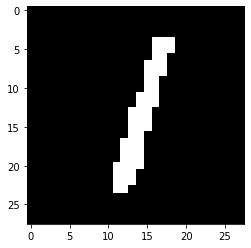

In [44]:
#just getting one image to feed in the network

img, label = test_data[2]
print(label)
plt.imshow(img.squeeze(), cmap="gray")
output = model_test_printer(img)
print(output)
pred = output.data.max(1, keepdim=True)[1]
print(pred)
print(img)

In [43]:
#Convert the flatten input into a csv
in_flatten = flatten_x.cpu().detach().numpy()

df_in_flatten = pd.DataFrame(in_flatten).astype(int)

#Export to csv with pandas 
df_in_flatten.to_csv('baseline/input_number_4_output_8.txt',index=False,header=False)


# Testing the multiplications


In [ ]:
# the output of the first layer should be the flattened input vector times the weight matrix of first layer
# lets first see the shapes of these two 
# size returns (row,column)

print("shape of flatten input",flatten_x.shape )
print("------------layer 1-----------") 
print("shape weight fc1",model_test_printer.fc1.weight.shape)
print("shape of fc1 output",fc1_out.shape)
print("shape of fc1 signed output",signed_fc1_out.shape)
print("------------layer 2-----------") 
print("shape weight fc2",model_test_printer.fc2.weight.shape)
print("shape of fc2 output",fc2_out.shape)
print("shape of fc2 signed output",signed_fc2_out.shape)
print("------------layer 3-----------") 
print("shape weight fc3",model_test_printer.fc3.weight.shape)
print("shape of fc3 output",fc3_out.shape)
print("shape of fc3 signed output",signed_fc3_out.shape)
print("shape of output",fc4_out.shape )
print("------------layer 4-----------") 
print("shape weight fc4",model_test_printer.fc4.weight.shape)
print("shape of fc4 output",fc4_out.shape)





In [23]:
#I am now going to verify the operations one by one to make sure dimensions are corrects and also results 

#LAYER 1 -> sing(flatten_x*fc1.weightT)
fc1_out_mine = my_sign(torch.matmul(flatten_x,torch.transpose(model_test_printer.fc1.weight,1,0)))
print("layer 1 op is: ",torch.all(fc1_out_mine.eq(signed_fc1_out)))

#save the output of LAYER 1
#Convert the flatten input into a csv
out_1= signed_fc1_out.cpu().detach().numpy()
out_1_d = pd.DataFrame(out_1).astype(int)
out_1_d[:] = out_1_d[:].replace([-1],0)
out_1_d.to_csv('baseline/layer_1_out.txt',index=False,header=False)

#LAYER 2 -> sing(fc1_out_mine*fc2.weightT)
fc2_out_mine = my_sign(torch.matmul(fc1_out_mine,torch.transpose(model_test_printer.fc2.weight,1,0)))
print("layer 2 op is: ",torch.all(fc2_out_mine.eq(signed_fc2_out)))

#save the output of LAYER 2 
#Convert the flatten input into a csv
out_2= signed_fc2_out.cpu().detach().numpy()
out_2_d = pd.DataFrame(out_2).astype(int)
out_2_d[:] = out_2_d[:].replace([-1],0)
out_2_d.to_csv('baseline/layer_2_out.txt',index=False,header=False)

#LAYER 3 -> sing(fc2_out_mine*fc3.weightT)
fc3_out_mine = my_sign(torch.matmul(fc2_out_mine,torch.transpose(model_test_printer.fc3.weight,1,0)))
print("layer 3 op is: ",torch.all(fc3_out_mine.eq(signed_fc3_out)))

#save the output of LAYER 3 
#Convert the flatten input into a csv
out_3= signed_fc3_out.cpu().detach().numpy()
out_3_d = pd.DataFrame(out_3).astype(int)
out_3_d[:] = out_3_d[:].replace([-1],0)
out_3_d.to_csv('baseline/layer_3_out.txt',index=False,header=False)

#LAYER 4 (output) -> fc3_out_mine*fc4.weightT
fc4_out_mine = torch.matmul(fc3_out_mine,torch.transpose(model_test_printer.fc4.weight,1,0))
print("output op is: ",torch.all(fc4_out_mine.eq(fc4_out)))

#save the output of LAYER 4
#Convert the flatten input into a csv
out_4= fc4_out.cpu().detach().numpy()
out_4_d = pd.DataFrame(out_4).astype(int)
out_4_d.to_csv('baseline/output.txt',index=False,header=False)

print("my output tensor: ",fc4_out_mine )
print("network output tensor: ",fc4_out)



layer 1 op is:  tensor(True)
layer 2 op is:  tensor(True)
layer 3 op is:  tensor(True)
output op is:  tensor(True)
my output tensor:  tensor([[ -2., -18., -10.,   4., -20.,  16., -20.,  18., -10.,  14.]],
       grad_fn=<MmBackward0>)
network output tensor:  tensor([[ -2., -18., -10.,   4., -20.,  16., -20.,  18., -10.,  14.]],
       grad_fn=<MmBackward0>)


In [ ]:
x = [0,1,1,0,1,0,1,0,0,0,0,0,0,0,1,1,1,0,1,1,1,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,1,1,1,0,0,0,1,0,0,0,0,1,1,1,0,0,1,1,1,0,1,1,1,1,1,1,0,0,0,1,1,0,0,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,0,0,0,0,0,0,1,0,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,0,1,1,1,1,1,1,1,0,0,1,0,1,1,0,1,0,1,0,0,0,0,0,0,1,1,1,1,0,0,1,1,1,1,1,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,1,1,1,1,1,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,1,1,1,1,1,0,0,0,0,1,1,1,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,1,0,0,0,0,0,0,1,1,1,0,1,1,0,1,0,1,0,0,0,0,0,1,1,1,1,0,0,1,0,0,0,0,0,0,1,1,1,1,1,0,0,1,1,1,1,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,1,0,0,0,0,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,1,1,1,0,1,1,1,1,1,0,0,0,0,0,0,1,1,1,0,1,1,0,0,1,0,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,0,1,1,1,1,1,1,0,0,0,1,1,1,1,0,1,1,1,1,1,1,0,0,1,1,1,1,1,0,1,1,1,1,1,0,0,0,1,0,0,1,0,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0,0,0,0,1,0,0,0,0,1,1,1,1,1,1,0,1,1,0,1,1,1,1,0,1,1,1,0,0,0,0,0,0,1,0,1,1,1,0,1,1,0,1,1,0,1,0,0,1,0,1,0,1,1,1,1,0,0,0,0,1,0,1,1,1,0,1,1,1,0,0,1,0,0,1,0,1,1,1,1,1,1,1,1,0,0,0,1,1,1,0,1,0,1,1,1,1,0,0,1,0,0,1,1,1,1,1,1,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,1,1,1,1,0,1,1,1,1,1,1,1,0,0,0,1,0,0,1,1,1,0,0,1,0,1,0,0,1,1,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1]
y = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

In [ ]:
sum = 0
for i in range(len(x)):
    sum = sum + x[i]*y[i]

In [ ]:
hah =torch.matmul(flatten_x,torch.transpose(model_test_printer.fc1.weight,1,0))


In [ ]:
my_sign(hah)

In [ ]:
flatten_x,torch

In [ ]:
torch.set_printoptions(linewidth=200)
g = torch.transpose(model_test_printer.fc1.weight,1,0)
